# Finetune a Custom Encoder on the DAGHAR Dataset


In this notebook, we will fine-tune a custom encoder (previously trained elsewhere) on the DAGHAR KuHAR dataset. The encoder can be **any `torch.nn.Module` that was trained elsewhere** and whose checkpoint is available at a `.ckpt` file (saved using `torch.save(model.state_dict())`). This file may contain only the weights from encoder or may contains the weights of the entire model, including the encoder.

To do this, we will first define yor model by:
1. Loadig the encoder from the checkpoint, using the `FromPretrained` class. We going to call this encoder as `backbone`.
2. Calculating the embedding size of the `backbone`. This is necessary to define the head of the model. This is done by passing a dummy input through the `backbone` and checking the output shape.
3. Defining the head of the model. We use a standard MLP classifier as the head, whose input size is the embedding size, followed by a hidden layer of 128 units and an output layer with the number of classes in the dataset, that is, 6.
4. Creating a `SimpleSupervisedModel` with the `backbone` and the head. The `SimpleSupervisedModel` is a PyTorch Lightning module that receives the `backbone` and the head as arguments and trains the model end-to-end. This model simply forwards the input through the `backbone`, flattens the output, and passes it through the head to get the logits, whose loss is calculated using the cross-entropy loss.

Note that, for sake of reproducibility, you should only change parts related to loading the encoder and defining the head of the model. The rest of the code should remain the same (or at least very similar) to the one provided in this notebook.

**Notes:**
1. The `backbone` should have a `forward` method that takes a batch of time series as input and returns the output of the encoder (embeddings). Your encoder must accept samples with the shape `(batch_size, channels, steps)`, where `channels` is the number of channels in the time series and `steps` is the number of time steps. For DAGHAR dataset, `channels=6` and `steps=60`. **Thus, your encoder should accept samples with the shape `(batch_size, 6, 60)`.**



In [1]:
# You should install minerva before running this script

# !pip install git+https://github.com/discovery-unicamp/Minerva-Dev.git
# !pip install kaleido

In [2]:
from datetime import datetime

import lightning as L
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from minerva.models.ssl.cpc import CPC
from minerva.models.nets.cpc_networks import HARCPCAutoregressive
from minerva.data.data_modules.har_rodrigues_24 import HARDataModuleCPC
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from minerva.models.nets.base import SimpleSupervisedModel

from minerva.models.nets.tnc import TSEncoder
import torchmetrics

from minerva.data.data_modules.har import MultiModalHARSeriesDataModule
from minerva.models.loaders import FromPretrained
from minerva.models.nets.base import SimpleSupervisedModel
from minerva.models.nets.mlp import MLP
from minerva.analysis.metrics.balanced_accuracy import BalancedAccuracy
from minerva.analysis.model_analysis import TSNEAnalysis

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Name of the experiment
execution_id = f'run_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
# Directory to save logs
log_dir = f"./logs/WISDM/{execution_id}" 


print(f"Execution ID: {execution_id}")
print(f"Log dir: {log_dir}")

Execution ID: run_20241105-001354
Log dir: ./logs/WISDM/run_20241105-001354


## Fine-tuning a Pre-trained Custom Encoder

In this notebook, we will fine-tune a custom encoder on the DAGHAR dataset. The encoder can be any `torch.nn.Module` that was trained elsewhere and whose checkpoint is available at a `.ckpt` file (saved using `torch.save(model.state_dict())`). This file may contain only the weights from encoder or may contains the weights of the entire model, including the encoder.

### 1. Defining the Data Module

We will use the `MultiModalHARSeriesDataModule` data module to load the DAGHAR dataset for fine-tuning. This data module loads the data in the format required for fine-tuning, which includes sliding window time series data for each sample. Thus, each sample of the dataset will be a 2-element tuple containing the time series (`6x60`, where 6 is the number of features and 60 is the window size) and the corresponding label.

The data module requires the following arguments:
- `data_path`: Path to the directory containing the dataset (change it to use other dataset from DAGHAR).
- `feature_prefix`: The prefix of the columns containing the features. For each prefix, we will create a different channel with all columns that start with the prefix.
- `label`: The name of the column containing the labels.
- `features_as_channels`: If True, for each prefix, we will create a different channel with all columns that start with the prefix. If False, we will concatenate all columns with the same prefix into a single channel (the sample will be a tensor of 1x360 instead of 6x60).
- `cast_to`: The data type to cast the features (float32).
- `batch_size`: The batch size for training.

In [4]:
data_module = MultiModalHARSeriesDataModule(
    data_path="/workspaces/container-workspace/standardized_view/WISDM",
    feature_prefixes=["accel-x", "accel-y", "accel-z", "gyro-x", "gyro-y", "gyro-z"],
    label="standard activity code",
    features_as_channels=True,
    cast_to="float32",
    batch_size=64,
    num_workers=1,
)

data_module

MultiModalHARSeriesDataModule(data_path=[PosixPath('/workspaces/container-workspace/standardized_view/WISDM')], batch_size=64)

### 2. Defining the Fine-tuning Model

We first going to create the `backbone` of our model, that is our encoder. To do this, we:
1. Copy-and-paste the code of the encoder in the cell below. Should be a `torch.nn.Module` or equivalent. You should copy all code necessary to define the encoder, including imports, class definition, the `forward` method, and any other methods or classes that are necessary to define the encoder.
2. Load the weights of the encoder from the checkpoint file using the `FromPretrained` class. This class receives the path to the checkpoint file and the model class and loads the weights from the checkpoint to the model. The `FromPretrained` class is a simple wrapper around the `torch.load` function that loads the weights from the checkpoint to the model.

**NOTE**: 
1. For sake of tutorial, we will create a dummy encoder and save the random weights to a checkpoint file. You should replace the dummy encoder with your encoder and the checkpoint file with the file containing the weights of your encoder.
2. Your encoder **must accept samples with the shape `(batch_size, 6, 60)`**. This is the shape of the samples in the DAGHAR dataset. If your encoder does not accept samples with this shape, you should modify it to accept samples with this shape.

#### Encoder Definition*

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import math
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
#from einops import rearrange, reduce, repeat
#from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary   
        
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        '''
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        '''
        queries = self.rearrange_tensor(self.queries(x),  num_heads=self.num_heads)
        keys = self.rearrange_tensor(self.keys(x), num_heads=self.num_heads)
        values = self.rearrange_tensor(self.values(x),  num_heads=self.num_heads)

        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        #print(f'out shape: {out.shape}')
        #out = rearrange(out, "b h n d -> b n (h d)")
        b, h, n, d = out.shape
        out = out.permute(0, 2, 1, 3).reshape(b, n, h * d)
        #print(f'out final shape: {out.shape}')
        out = self.projection(out)
        return out
    
    def rearrange_tensor(self, x: Tensor, num_heads: int) -> Tensor:
        """
        Rearrange tensor from shape (b, n, h * d) to (b, h, n, d).

        Args:
            x (Tensor): Input tensor with shape (b, n, h * d).
            num_heads (int): Number of heads (h).

        Returns:
            Tensor: Rearranged tensor with shape (b, h, n, d).
        """
        b, n, hd = x.shape
        d = hd // num_heads  # Calcula a dimensão `d` dividindo pela quantidade de cabeças

        # Redimensiona para (b, n, h, d) e reorganiza para (b, h, n, d)
        return x.view(b, n, num_heads, d).permute(0, 2, 1, 3)

    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

        
        
class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])
        

class ReduceLayer(nn.Module):
    def __init__(self, reduction: str = 'mean'):
        super(ReduceLayer, self).__init__()
        self.reduction = reduction

    def forward(self, x: Tensor) -> Tensor:
        if self.reduction == 'mean':
            return x.mean(dim=1)  # Reduz ao longo da dimensão `n`, resultando em (b, e)
        elif self.reduction == 'sum':
            return x.sum(dim=1)
        else:
            raise ValueError(f"Unsupported reduction type: {self.reduction}")
    
class PatchEmbedding_Linear(nn.Module):
    #what are the proper parameters set here?
    def __init__(self, in_channels = 21, patch_size = 16, emb_size = 100, seq_len = 1024):
        # self.patch_size = patch_size
        super().__init__()
        #change the conv2d parameters here
        '''
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1 = 1, s2 = patch_size),
            nn.Linear(patch_size*in_channels, emb_size))
        '''
        self.projection = nn.Sequential(
            RearrangeLayer(patch_size=patch_size, s1=1),  # Substitui o Rearrange do einops
            nn.Linear(patch_size * in_channels, emb_size))
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_len // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(dim=2)
        b, _, _, _ = x.shape
        x = self.projection(x)
        
        #cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        cls_tokens = self.cls_token.repeat(b, 1, 1) #Personal repeat from pytorch to transfer from einops

        #prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # position
        x += self.positions
        return x     
    
    #For use in change of Rearrange einops layer
class RearrangeLayer(nn.Module):
    def __init__(self, patch_size: int, s1: int = 1):
        super(RearrangeLayer, self).__init__()
        self.patch_size = patch_size
        self.s1 = s1

    def forward(self, x: Tensor) -> Tensor:
        b, c, h_s1, w_s2 = x.shape
        h, s1 = h_s1, self.s1
        w, s2 = w_s2 // self.patch_size, self.patch_size
        
        # Rearrange tensor
        x = x.view(b, c, h, s1, w, s2)  # shape: (b, c, h, s1, w, s2)
        x = x.permute(0, 2, 4, 3, 5, 1)  # shape: (b, h, w, s1, s2, c)
        x = x.reshape(b, h * w, s1 * s2 * c)  # shape: (b, h * w, s1 * s2 * c)  

        return x
        
class Encoder(nn.Sequential):
    def __init__(self, 
                 in_channels=3,
                 patch_size=15,
                 emb_size=50, 
                 seq_len = 150,
                 depth=3,  
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_len),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
        )


In [6]:
# REPLACE THIS WITH YOUR ENCODER CHECKPOINT PATH
ckpt_path = "/workspaces/container-workspace/tts-gan/pre-trained-models/daghar_all_dataset/seq_len_60/daghar_all_50000_6axis_60_100/UCI_DAGHAR_Multiclass_50000_D_60_6axis_2024_11_03_22_59_20/Model/checkpoint"

You should comment the cell below. It is only use to save the dummy encoder to a checkpoint file. When you replace it with your encoder, you should remove this cell.

In [7]:
# COMMENT THIS CELL! It is only here to illustrate a chekpoint. YOU SHOULD USE YOUR OWN ENCODER CHECKPOINT
'''
torch.save(DummyEncoder().state_dict(), ckpt_path)
print(f"Encoder saved at '{ckpt_path}'")
print("You should remove this torch.save for the final version of your code")
'''

'\ntorch.save(DummyEncoder().state_dict(), ckpt_path)\nprint(f"Encoder saved at \'{ckpt_path}\'")\nprint("You should remove this torch.save for the final version of your code")\n'

#### Instantiating the Encoder and Loading it from Checkpoint*

We will load the encoder from the checkpoint file using the `FromPretrained` class. This class receives the following parameters:
- `model`: is a instance of the model class with random weights. We going to replace the weights of this model with the weights from the checkpoint.
- `ckpt_path`: is the path to the checkpoint file containing the weights of the encoder.
- `filter_keys`: optional parameter that can be used to filter the keys of the checkpoint file. If provided, only the keys that contain the filter keys will be loaded to the model. This is useful when the checkpoint file contains the weights of the entire model and we want to load only the weights of the encoder.
- `strict`: if True, the keys of the checkpoint file must match the keys of the model exactly. If False, the keys of the checkpoint file must contain the keys of the model. We usually set this parameter to False to allow loading only the weights of the encoder.
- `keys_to_rename`: a dictionary that maps the keys of the checkpoint file to the keys of the model. This is useful when the keys of the checkpoint file do not match the keys of the model. We can rename the keys of the checkpoint file to match the keys of the model.

In [8]:
# Instantiating encoder (random weights)
backbone = Encoder(in_channels=6, seq_len=60)

# Loading encoder from checkpoint
backbone = FromPretrained(
    model=backbone,
    ckpt_path=ckpt_path,
    strict=False,
    ckpt_key='dis_state_dict'
)
backbone

Model loaded from /workspaces/container-workspace/tts-gan/pre-trained-models/daghar_all_dataset/seq_len_60/daghar_all_50000_6axis_60_100/UCI_DAGHAR_Multiclass_50000_D_60_6axis_2024_11_03_22_59_20/Model/checkpoint: _IncompatibleKeys(missing_keys=[], unexpected_keys=['2.clshead.1.weight', '2.clshead.1.bias', '2.clshead.2.weight', '2.clshead.2.bias'])


/workspaces/container-workspace/Minerva-Dev/minerva/models/loaders.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Encoder(
  (0): PatchEmbedding_Linear(
    (projection): Sequential(
      (0): RearrangeLayer()
      (1): Linear(in_features=90, out_features=50, bias=True)
    )
  )
  (1): Dis_TransformerEncoder(
    (0): Dis_TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (keys): Linear(in_features=50, out_features=50, bias=True)
            (queries): Linear(in_features=50, out_features=50, bias=True)
            (values): Linear(in_features=50, out_features=50, bias=True)
            (att_drop): Dropout(p=0.5, inplace=False)
            (projection): Linear(in_features=50, out_features=50, bias=True)
          )
          (2): Dropout(p=0.5, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
          (1): FeedForwardBlock(
            (0): Linear(in_feature

#### Defining the head

We will define the head of the model. The head is a simple MLP classifier that receives the embeddings from the encoder and outputs the logits. The head consists of a single hidden layer with 128 units and an output layer with the number of classes in the dataset, that is, 6.
In order to know the input size of the head, we need to calculate the embedding size of the encoder. This is done by passing a dummy input through the encoder and checking the output shape. Let's pick the first batch of the training data and pass it through the encoder to get the embedding size.

In [9]:
# Pega os dataloader de treino
data_module.setup("fit")
train_data_loader = data_module.train_dataloader()

# Obtem o primeiro batch de treino (64 amostras de 6x60)
first_batch = next(iter(train_data_loader))

X, y = first_batch
print(f"O primeiro batch de treino tem shape X={tuple(X.shape)} e y={tuple(y.shape)}")

O primeiro batch de treino tem shape X=(64, 6, 60) e y=(64,)


We made a single forward pass through the encoder with the first batch of the training data and checked the output shape that is `(64, 16, 60)`. The embedding size is `16 x 30 = 480`, that is, the product of the number of channels and the number of steps in the output of the encoder. Thus, the input layer of our MLP head will have 480 units.

In [10]:
embeddings = backbone(X)
mlp_input_shape = embeddings.shape[1] * embeddings.shape[2]
print(f"O embedding tem shape {tuple(embeddings.shape)}")
print(f"O embedding final, achatado, tem o shape de {mlp_input_shape}")

O embedding tem shape (64, 5, 50)
O embedding final, achatado, tem o shape de 250


Let's define the head of the model in the cell below. The head will be a simple MLP classifier with:
- A input layer with 480 units (`mlp_input_shape` variable).
- A hidden layer with 128 units.
- An output layer with 6 units, that is the number of classes in the dataset (`num_classes` variable).

In [11]:
num_classes = 6
head = MLP([mlp_input_shape, 128, num_classes])
head

MLP(
  (0): Linear(in_features=250, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=6, bias=True)
)

#### Defining the SimpleSupervisedModel

Finally, we use the `SimpleSupervisedModel` class to create the supervised model with the encoder as the backbone and the MLP classifier as the head. The `SimpleSupervisedModel` class requires the following arguments:
- `backbone`: The backbone model (`FromPretrained` model).
- `fc`: The head model (the MLP classifier).
- `loss_fn`: The loss function to use for training (`CrossEntropyLoss`).
- `flatten`: Whether to flatten the input before passing it through the head. Usually, the input is flattened if the backbone outputs a tensor with more than two dimensions.
- `train_metrics`: A dictionary where the keys are the names of the metrics and the values are the functions that calculate the metrics. The metrics function should use `torchmetrics` API to calculate the metrics.
- `val_metrics`: A dictionary where the keys are the names of the metrics and the values are the functions that calculate the metrics. The metrics function should use `torchmetrics` API to calculate the metrics.

In [12]:
model = SimpleSupervisedModel(
    backbone=backbone,
    fc=head,
    loss_fn=torch.nn.CrossEntropyLoss(),
    flatten=True,
    train_metrics={
        "acc": torchmetrics.Accuracy(task="multiclass", num_classes=6),
    },
    val_metrics={
        "acc": torchmetrics.Accuracy(task="multiclass", num_classes=6),
    },
)

model

SimpleSupervisedModel(
  (backbone): Encoder(
    (0): PatchEmbedding_Linear(
      (projection): Sequential(
        (0): RearrangeLayer()
        (1): Linear(in_features=90, out_features=50, bias=True)
      )
    )
    (1): Dis_TransformerEncoder(
      (0): Dis_TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (keys): Linear(in_features=50, out_features=50, bias=True)
              (queries): Linear(in_features=50, out_features=50, bias=True)
              (values): Linear(in_features=50, out_features=50, bias=True)
              (att_drop): Dropout(p=0.5, inplace=False)
              (projection): Linear(in_features=50, out_features=50, bias=True)
            )
            (2): Dropout(p=0.5, inplace=False)
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((50,), eps=1e-05, element

### 3. Defining the Pytorch Lightning Trainer Configuration

We will define the PyTorch Lightning Trainer configuration for fine-tuning the model.

The trainer configuration includes the following parameters:
- `max_epochs`: The maximum number of epochs to train the model.
- `accelerator`: The accelerator to use for training: `cpu`, `gpu`, or `tpu`.
- `devices`: The number of accelerators to use for training.
- `logger`: The logger to use for logging the training progress.
- `limit_*_batches`: The number of batches to use for training and validation. **This is useful for debugging and testing the model.**. You should remove these parameters when training the model for real.

In [13]:
## Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/',
    monitor='val_loss',
    mode='min',
    save_last=True
)

## Logger
logger = CSVLogger(save_dir=log_dir, name='tts-finetune', version=execution_id)

## Trainer
trainer = L.Trainer(
    # Maximum number of epochs to train
    max_epochs=100,
    # Training on GPU
    accelerator="gpu",
    # We will train using 1 gpu
    devices=1,
    # Logger for logging
    logger=logger,
    # List of callbacks
    callbacks=[checkpoint_callback],
    # Only for testing. Remove for production. We will only train using 1 batch of training and validation
    #limit_train_batches=1,
    #limit_val_batches=1,
)

trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 4. Creating the fine-tuning pipeline (and running the training)

We will create a `SimpleLightningPipeline` to fine-tune the model. This pipeline receives the following arguments:
- `model`: The model to train.
- `trainer`: The PyTorch Lightning Trainer to use for training.
- `log_dir`: The directory to save the logs, checkpoints, and other artifacts of the training process.
- `save_run_status`: If True, save the status of the run to the log directory. This is useful for reprodutibility purposes.
- `seed`: The seed to use for random number generators in PyTorch, NumPy, and other libraries.

This pipeline is optional, as user can simply use `trainer.fit(model, datamodule)` directly to train the model. However, the pipeline provides a more organized way to train the model and save required information for reproducibility.

In [14]:
train_pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    log_dir=log_dir,
    save_run_status=True,
    seed=42
)

Seed set to 42


Log directory set to: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354


Run the pipeline to fine-tune the model on the DAGHAR dataset!

In [15]:
train_pipeline.run(data_module, task="fit")

Pipeline info saved at: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/run_2024-11-05-00-13-55c8e4cc692fa441b3b7e15a188007a8e0.yaml


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | Encoder          | 96.8 K | train
1 | fc       | MLP              | 32.9 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.519     Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 136/136 [00:01<00:00, 77.19it/s, v_num=1354, val_loss=0.381, val_acc=0.850, train_loss=0.169, train_acc=0.928]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 136/136 [00:01<00:00, 73.55it/s, v_num=1354, val_loss=0.381, val_acc=0.850, train_loss=0.169, train_acc=0.928]
Pipeline info saved at: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/run_2024-11-05-00-13-55c8e4cc692fa441b3b7e15a188007a8e0.yaml


## Evaluating the Fine-tuned Model

After fine-tuning the encoder on the DAGHAR dataset, we will evaluate the model's performance on the test set of the same dataset. We create a simple evaluation pipeline, that will:
1. Run forward on test set.
2. Calculcate the metrics. This is specified in the `classification_metrics` dictionary, where the keys are the names of the metrics and the values are the functions that calculate the metrics. The metrics function should use `torchmetrics` API to calculate the metrics.
3. Perform model analysis, such as plot t-sne embeddings.

The test pipeline requires the following arguments:
- `model`: The fine-tuned model to evaluate.
- `trainer`: The PyTorch Lightning Trainer configuration.
- `log_dir`: The directory to save the evaluation logs.
- `seed`: The random seed for reproducibility.
- `classification_metrics`: A dictionary where the keys are the names of the metrics and the values are the functions that calculate the metrics. The metrics function should use `torchmetrics` API to calculate the metrics.
- `model_analysis`: A function that performs model analysis, such as plotting t-sne embeddings.

Finally, we run the evaluation pipeline with the test data module to evaluate the model on the test set. We set the `task` parameter of the `run` method to `evaluate` to evaluate the model on the test set.

In [16]:
test_pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    log_dir=log_dir,
    save_run_status=True,
    seed=42,
    classification_metrics={
        "accuracy": torchmetrics.Accuracy(num_classes=6, task="multiclass"),
        "f1": torchmetrics.F1Score(num_classes=6, task="multiclass"),
        "precision": torchmetrics.Precision(num_classes=6, task="multiclass"),
        "recall": torchmetrics.Recall(num_classes=6, task="multiclass"),
        "balanced_accuracy": BalancedAccuracy(num_classes=6, task="multiclass"),
    },
    apply_metrics_per_sample=False,
      model_analysis={
         "tsne": TSNEAnalysis(
             height=800,
             width=800,
             legend_title="Activity",
             title="t-SNE of CPC Finetuned on KuHar",
             output_filename="tsne_cpc_finetuned_kuhar.pdf",
             label_names={
                 0: "sit",
                 1: "stand",
                 2: "walk",
                 3: "stair up",
                 4: "stair down",
                 5: "run",
                 6: "stair up and down",
             },
         )
     },
)

Seed set to 42


Log directory set to: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354


In [17]:
d= test_pipeline.run(
    data_module, task="evaluate", ckpt_path=checkpoint_callback.best_model_path
)
d

Pipeline info saved at: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/run_2024-11-05-00-17-05c2ecbfb919bd4da5ba3227e13f929560.yaml


Restoring states from the checkpoint path at /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/checkpoints/epoch=46-step=6392.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/checkpoints/epoch=46-step=6392.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:00<00:00, 299.08it/s]
Running classification metrics...
Running model analysis...


/workspaces/container-workspace/Minerva-Dev/minerva/analysis/metrics/balanced_accuracy.py:58: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/workspaces/container-workspace/Minerva-Dev/minerva/analysis/model_analysis.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X, device="cpu")


t-SNE plot saved to /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/tsne_cpc_finetuned_kuhar.pdf
{'classification': {'accuracy': [0.8629032373428345], 'f1': [0.8629032373428345], 'precision': [0.8629032373428345], 'recall': [0.8629032373428345], 'balanced_accuracy': [0.8630374670028687]}, 'analysis': {'tsne': '/workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/tsne_cpc_finetuned_kuhar.pdf'}}
Metrics saved to /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/metrics_2024-11-05-00-17-05c2ecbfb919bd4da5ba3227e13f929560.yaml
Pipeline info saved at: /workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/run_2024-11-05-00-17-05c2ecbfb919bd4da5ba3227e13f929560.yaml


{'classification': {'accuracy': [0.8629032373428345],
  'f1': [0.8629032373428345],
  'precision': [0.8629032373428345],
  'recall': [0.8629032373428345],
  'balanced_accuracy': [0.8630374670028687]},
 'analysis': {'tsne': '/workspaces/container-workspace/Minerva-Dev/docs/notebooks/examples/time_series/har/kuhar_daghar/logs/WISDM/run_20241105-001354/tsne_cpc_finetuned_kuhar.pdf'}}

In [4]:
import yaml
import os
import glob
import numpy as np
import pandas as pd
import dataframe_image as dfi

# Define the root directory
root = "./logs/"
dictionary = {}

#Loop over each dataset directory inside the root
for dataset in os.listdir(root):
    dataset_path = os.path.join(root, dataset)
      
        # Loop over each run directory within the dataset directory
    accuracy = []
    balancedaccuracy = []
    f1 = []
    precision = []
    recall = []
    
    for run in os.listdir(dataset_path):
        run_path = os.path.join(dataset_path, run)
                
        # Look for the metrics file with the specified pattern in the run directory
        metrics_file = glob.glob(os.path.join(run_path, 'metrics_????-??-??-??-??-*.yaml'))

        # Read the YAML file
        with open(metrics_file[0], 'r') as file:
            data = yaml.safe_load(file)
                        
        # Extract the 'classification' dictionary if it exists
        classification_data = data.get('classification')
        print(dataset, classification_data)
        accuracy.append(classification_data['accuracy'])
        balancedaccuracy.append(classification_data['balanced_accuracy'])
        f1.append(classification_data['f1'])
        precision.append(classification_data['precision'])
        recall.append(classification_data['recall'])

    dictionary[dataset] = {'accuracy': f'{np.array(accuracy).mean():.4f} ± {np.array(accuracy).std():.4f}',
                           'balanced acurracy':  f'{np.array(balancedaccuracy).mean():.4f} ± {np.array(balancedaccuracy).std():.4f}',
                           'f1':  f'{np.array(f1).mean():.4f} ± {np.array(f1).std():.4f}',
                           'precision':  f'{np.array(precision).mean():.4f} ± {np.array(precision).std():.4f}',
                           'recall':  f'{np.array(recall).mean():.4f} ± {np.array(recall).std():.4f}'}
    
# Criando o DataFrame
df = pd.DataFrame(dictionary).T

# Aplicando estilo com fundo branco e bordas sutis
styled_df = (
    df.style
    .set_properties(**{'background-color': 'white', 'color': 'black', 'border-color': 'lightgray'})
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('border-color', 'gray'), ('font-weight', 'bold')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f9f9f9')]}
    ])
    .set_caption("Metricas de Performance por Dataset")  # Adiciona um título ao DataFrame
)

styled_df


UCI {'accuracy': [0.8579710125923157], 'balanced_accuracy': [0.8582032322883606], 'f1': [0.8579710125923157], 'precision': [0.8579710125923157], 'recall': [0.8579710125923157]}
UCI {'accuracy': [0.834782600402832], 'balanced_accuracy': [0.8668681979179382], 'f1': [0.834782600402832], 'precision': [0.834782600402832], 'recall': [0.834782600402832]}
UCI {'accuracy': [0.8550724387168884], 'balanced_accuracy': [0.8557836413383484], 'f1': [0.8550724387168884], 'precision': [0.8550724387168884], 'recall': [0.8550724387168884]}
UCI {'accuracy': [0.8637681007385254], 'balanced_accuracy': [0.8662659525871277], 'f1': [0.8637681007385254], 'precision': [0.8637681007385254], 'recall': [0.8637681007385254]}
UCI {'accuracy': [0.8710144758224487], 'balanced_accuracy': [0.8748836517333984], 'f1': [0.8710144758224487], 'precision': [0.8710144758224487], 'recall': [0.8710144758224487]}
WISDM {'accuracy': [0.8579109311103821], 'balanced_accuracy': [0.8586177229881287], 'f1': [0.8579109311103821], 'precis

,accuracy,balanced acurracy,f1,precision,recall
UCI,0.8565 ± 0.0122,0.8644 ± 0.0068,0.8565 ± 0.0122,0.8565 ± 0.0122,0.8565 ± 0.0122
WISDM,0.8581 ± 0.0066,0.8594 ± 0.0055,0.8581 ± 0.0066,0.8581 ± 0.0066,0.8581 ± 0.0066
realworld_waist,0.6989 ± 0.0269,0.7447 ± 0.0230,0.6989 ± 0.0269,0.6989 ± 0.0269,0.6989 ± 0.0269
realworld_thigh,0.6624 ± 0.0096,0.6603 ± 0.0045,0.6624 ± 0.0096,0.6624 ± 0.0096,0.6624 ± 0.0096
motionsense,0.8851 ± 0.0029,0.8886 ± 0.0017,0.8851 ± 0.0029,0.8851 ± 0.0029,0.8851 ± 0.0029
kuhar,0.5708 ± 0.0167,0.5721 ± 0.0287,0.5708 ± 0.0167,0.5708 ± 0.0167,0.5708 ± 0.0167


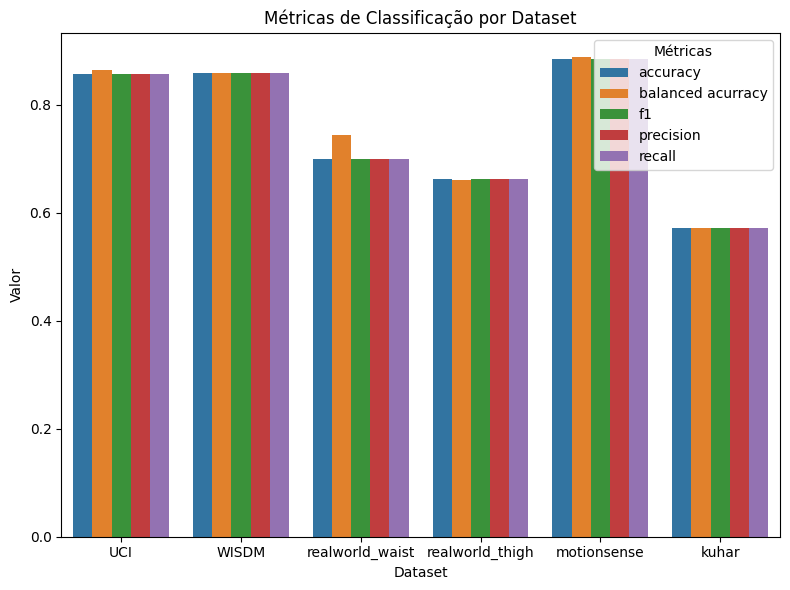

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertendo as métricas para float para visualização
df_numeric = df.replace(r' ± .*', '', regex=True).astype(float)

# Criando um gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(data=df_numeric.reset_index().melt(id_vars='index'), 
            x='index', y='value', hue='variable')
plt.title('Métricas de Classificação por Dataset')
plt.xlabel('Dataset')
plt.ylabel('Valor')
plt.legend(title='Métricas')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()